$\textbf{GOAL : }$ Implement ADMM, see if its promising pursue with new ideas.

> A Nonconvex Proximal Splitting Algorithm under Moreau-Yosida Regularization  
Emanuel Laude, Tao Wu, Daniel Cremers

# Theory

## Alternating Direction Method of Multipliers (ADMM)

Let $f_1,f_2$ lower semi continuous  <span style="color:red"><b>and other assumption, TODO : complete according to main paper of this notebook</b></span>
We consider
$$\min_{x\in\mathbb R^{n}}\;f_1(x_1)+f_2(x_2) \quad\text{s.t.}\quad A_1x_1+A_2x_2=b$$

The augmented Lagrangian is
$$\mathcal L_\rho(x_1,x_2,u)=f_1(x_1)+f_2(x_2)+u^{\top}(A_1x_1+A_2x_2-b)+\tfrac\rho2\lVert A_1x_1+A_2x_2-b\rVert^2$$

Replacing \$u\$ by the scaled* multiplier $w=u/\rho$ gives the succinct form used below. We did this to compactify the writting.  
We have
$
u^{\top}r+\tfrac{\rho}{2}\lVert r\rVert^{2}$ with $r:=A_1x_1+A_2x_2-b$

$$
u^{\top}r+\tfrac{\rho}{2}\|r\|^{2}
=\tfrac{\rho}{2}\bigl\|r+\tfrac{u}{\rho}\bigr\|^{2}-\tfrac{\rho}{2}\bigl\|\tfrac{u}{\rho}\bigr\|^{2}
=\tfrac{\rho}{2}\|r+w\|^{2}-\tfrac{\rho}{2}\|w\|^{2}
$$

> Dual methods and ADMM (p. 17) 
Barnabas Poczos & Ryan Tibshirani  
Convex Optimization 10-725/36-725  

For any $\rho>0$ the iterations

$$\begin{aligned}
 x_1^{k+1}&=\arg\min_{x_1}\,f_1(x_1)+\tfrac\rho2\lVert A_1x_1+A_2x_2^{k}-b+w^{k}\rVert^2\\
 x_2^{k+1}&=\arg\min_{x_2}\,f_2(x_2)+\tfrac\rho2\lVert A_1x_1^{k+1}+A_2x_2-b+w^{k}\rVert^2\\
 w^{k+1}&=w^{k}+A_1x_1^{k+1}+A_2x_2^{k+1}-b
\end{aligned}$$

$A_1$ and $A_2$ doesn't require to be full rank (see precedents slide : p.16)

## $P_\nu$

We study
$$F(\theta)=f(\theta)+\lambda P_{\nu}(\theta) \qquad f(\theta)=\sqrt{\operatorname{RSS}(\theta)}=\lVert y-X\theta\rVert_2$$
with $0<\nu<1$ and
$$P_{\nu}(\theta)=\sum_{i=1}^p\frac{|\theta_i|}{1+|\theta_i|^{1-\nu}}$$

Introduce an auxiliary copy $z$ of $\theta$,  <span style="color:red"><b>Reflechir à poser également $z=X\theta$</b></span>
$$
\min_{\theta,z}\;f(\theta)+\lambda P_{\nu}(z)\quad\text{s.t.}\;\theta-z=0
$$  

With $A_1=A_2=I$ and $b=0$


In our case, 
With the scaled dual $w$ and penalty parameter $\rho$
\begin{cases}
\theta^{k+1}=\arg\min_{\theta}\;f(\theta)+\tfrac\rho2\lVert\theta-z^{k}+w^{k}\rVert^2,\\[2mm]
 z^{k+1}=\operatorname{prox}_{\lambda P_{\nu}/\rho}\bigl(\theta^{k+1}+w^{k}\bigr),\\[2mm]
 w^{k+1}=w^{k}+\theta^{k+1}-z^{k+1}.
\end{cases}


## $\ell_1$


We study
$$F(\theta)=f(\theta)+\lambda ||\theta||_1$$

Introduce, 
<span style="color:red"><b>TODO : completer la theorie, le choxide la contrainte à poser et explicit le syteme à résoudre</b></span>


Introduce an auxiliary copy $z$ of $\theta$,  <span style="color:red"><b>Reflechir à poser également $z=X\theta$</b></span>
$$
\min_{\theta,z}\;f(\theta)+\lambda ||z||_1\quad\text{s.t.}\;\theta-z=0
$$  

With $A_1=A_2=I$ and $b=0$

In our case, set $f(\theta)=\lVert y-X\theta\rVert\_2$. With the scaled dual $w$ and penalty parameter $\rho>0$ the ADMM reads

$$
\begin{cases}
\theta^{k+1}=\arg\min_{\theta}\ f(\theta)+\tfrac\rho2\lVert\theta-z^{k}+w^{k}\rVert_2^2\\[2mm]
z^{k+1}=\operatorname{prox}_{\lambda\lVert\cdot\rVert_1/\rho}\bigl(\theta^{k+1}+w^{k}\bigr)\\[2mm]
w^{k+1}=w^{k}+\theta^{k+1}-z^{k+1}
\end{cases}
$$

The $\ell\_1$ proximal map is the componentwise soft thresholding with threshold $\lambda\rho$

$$
\bigl[\operatorname{prox}_{\lambda\lVert\cdot\rVert_1/\rho}(t)\bigr]_j=
\begin{cases}
t_j-\lambda/\rho & \text{if } t_j>\lambda/\rho\\
0 & \text{if } \lvert t_j\rvert\le\lambda/\rho\\
t_j+\lambda/\rho & \text{if } t_j<-\lambda/\rho
\end{cases}
$$


In [12]:
using LinearAlgebra, Statistics, Random, Printf, Plots

In [13]:
include("../functions/ISTA.jl")
include("../functions/metrics.jl")

import .ISTA: ista_L, ista
import .metrics: pesr, tpr, fdr, f1score

# Phases transitions $P_\nu$

## Setup

In [3]:
function lambda_local0(y, X; verbose=false)
    r = y .- mean(y)
    if verbose
        @printf("residu norm : %.12f\n", norm(r))
    end
    return maximum(abs.(X' * r)) / norm(r)
end

function lambda_qut_v(X; α=0.05, M=1000, rng=Random.GLOBAL_RNG, verbose=false)
    n = size(X,1)
    λvals = Vector{Float64}(undef, M)
    for m in 1:M
        y0 = randn(rng, n)
        λvals[m] = lambda_local0(y0, X; verbose=verbose)
    end
    return quantile!(λvals, 1-α)
end

lambda_qut_v (generic function with 1 method)

In [4]:
rho(x, ν)  = abs(x) / (1 + abs(x)^(1-ν))
rho_prime(x, ν) = (1 + ν*abs(x)^(1-ν)) / (1 + abs(x)^(1-ν))^2 

rho_prime (generic function with 1 method)

In [5]:
function bisection(f, a, b; tol=1e-10, maxiter=1000, verbose=false)
    if f(a)==0
        return a, 0
    end
    if f(b)==0
        return b, 0
    end
    
    if verbose
        @printf("start with a = %.12f : f(a) = %.12f, b = %.12f : f(b) = %.12f\n", a, f(a), b, f(b))
    end
    fa, fb = f(a), f(b)
    # TODO : attention ! special pour ce cas et se rappeler pourquoi
    while f(a)*f(b)>0
        b*=2
        if b> 1e10
            return a, -1
        end
        
    end
    # @assert fa * fb < 0 "Need f(a)f(b)<0 : $(fa) | $(fb)"
    for k in 1:maxiter
        m  = 0.5*(a+b)
        fm = f(m)
        if abs(fm) <= tol || 0.5*(b-a) <= tol
            if verbose
                @printf("bisection: found %.12f in %d iterations | a = %.12f, b = %.12f, f(a) = %.12f, f(b) = %.12f\n", m, k, a, b, fa, fb)
            end         
            return m, k
        elseif fm>0
            b, fb = m, fm
        else
            a, fa = m, fm
        end
    end
    error("No convergence in $maxiter iterations")
end

bisection (generic function with 1 method)

In [6]:
function kappa_phi(Γ::Float64, ν::Float64)
    T = eps(Float64)
    kappa_poly(κ) = κ^(2-ν) + 2κ + κ^ν + 2Γ*(ν-1) 
    κ, it = bisection(kappa_poly, 0.0, max(1.0, Γ*(1-ν)), verbose=false)
    φ = κ/2 +  Γ/(1 + κ^(1-ν))

    return κ, φ
end

kappa_phi (generic function with 1 method)

In [7]:
function x_tar(z::Float64, Γ::Float64, ν::Float64, κ::Float64)
    h(x) = x + Γ * rho_prime(x, ν) - z
    res, _ = bisection(h,κ,z; tol = 1e-10, verbose=false)
    return res
end

x_tar (generic function with 1 method)

In [8]:
function prox_harder_vec(z::AbstractVector, γ::Float64, λ::Float64, ν::Float64)
    if ν== 1.0 
        return sign.(z) .* max.(abs.(z) .- γ * λ*0.5, 0.0) # soft thresholding (see l_qut_1) # TODO page 4 harderLASSO pdf phi_1 (confirmer)
    end
    # else proximal operator for harder penalty
    Γ = γ * λ 
    κ, φ = kappa_phi(Γ, ν)    

    β_new = map(z[1:end-1]) do zi # coordinate loop
        abs(zi) ≤ φ - eps() ? 0.0 : sign(zi) * x_tar(abs(zi), Γ, ν, κ) 
    end
    return vcat(β_new, z[end])
end


prox_harder_vec (generic function with 1 method)

## Phase transition

In [9]:
function phase_transition_nu(n, p, s_list, ν; σ=0.1, B=20, α=0.05, tol=1e-9, seed=42)
    m = length(s_list)
    pesr_rate = zeros(m)
    f1_rate = zeros(m)
    fdr_rate = zeros(m)
    tpr_rate = zeros(m)

    Random.seed!(42)

    for (i, s) in enumerate(s_list)
        acc_pesr = acc_f1 = acc_fdr = acc_tpr = 0.0

        for _ in 1:B
            X = randn(n, p)
            X .-= mean(X; dims=1)
            X ./= std(X;  dims=1)

            β = zeros(p)
            β[randperm(p)[1:s]] .= 3
            β_hat = run_trial_nu(X, β, σ, ν; α=α, tol=tol, c_intercept=0)

            y, ŷ = abs.(β) .> 0, abs.(β_hat) .>tol

            acc_pesr += pesr(β, β_hat; tol=tol)
            acc_f1 += f1score(y, ŷ)
            acc_fdr += fdr(y, ŷ)
            acc_tpr += tpr(y, ŷ)
        end

        pesr_rate[i] = acc_pesr/B
        f1_rate[i] = acc_f1 /B
        fdr_rate[i] = acc_fdr/B
        tpr_rate[i] = acc_tpr/B
    end

    return s_list, pesr_rate, f1_rate, fdr_rate, tpr_rate
end

phase_transition_nu (generic function with 1 method)

## ADMM ($P_\nu$)

In [10]:
function admm_pnu(X, y, prox_pnu; lambda=0, nu=0.9, ρ = 1.0, max_iter = 1_000, inner_max = 50, tol = 1e-9)
    n, p = size(X)
    θ = zeros(p)
    z = zeros(p)
    w = zeros(p)
    # θ = ones(p)   # Initialize θ to ones for better convergence
    # z = ones(p)
    # w = ones(p)

    Xnorm = opnorm(X)  # ‖X‖₂ once for Lipschitz bound

    for k in 1:max_iter
        ## θ–update ::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        v = z .- w  # “current forcing term”
        θ = _theta_sub!(θ, v, X, y, ρ, Xnorm, inner_max, tol)

        ## z–update (separable prox) ::::::::::::::::::::::::::::::::::::::::
        z_old = copy(z)
        z = prox_pnu(θ + w, lambda / ρ)

        ## dual update :::::::::::::::::::::::::::::::::::::::::::::::::::::
        w .+= θ .- z

        ## monitors ::::::::::::::::::::::::::::::::::::::::::::::::::::::::
        r_pri = norm(θ - z)
        r_du = norm(ρ * (z .- z_old))  # dual residual
        (r_pri < tol && r_du < tol) && break
    end

    return θ
end


# –– helper ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
function _theta_sub!(θ, v, X, y, ρ, Xnorm, inner_max, tol)
    for _ in 1:inner_max
        r = y - X * θ
        nr = max(norm(r), 1e-12)
        g_f = -(X' * r) / nr
        grad = g_f + ρ * (θ - v)

        if norm(grad) < tol
            break
        end

        L = Xnorm^2 / nr + ρ  # coarse Lipschitz bound
        θ .-= grad ./ L
    end

    return θ
end


_theta_sub! (generic function with 1 method)

In [11]:
function run_trial_nu(X, β, σ, ν; α=0.05, tol=1e-9, max_iter=10_000, mu=1., c_intercept=0.0, verbose=false)
    n = size(X, 1)
    X̃ = hcat(X, ones(n)) # Ajout colonne d'intercept
    y = X * β .+ σ * mu *randn(n) .+ c_intercept
    
    λ_QUT = lambda_qut_v(X; α = α, M = 1000, verbose = false)

    θ  = zeros(p+1) 
    
    prox( z,γ ) = prox_harder_vec(z, γ, λ_QUT, ν)
    ρ = 1.
    θ= admm_pnu(X̃,y, prox;
        lambda      = λ_QUT,
        nu          = ν,
        ρ         = ρ,
        max_iter    = max_iter
    ) 
    # println("ADMM completed with final θ: ", θ.>tol, " sum = ", sum(θ.>tol))
    return θ[1:p]
end


run_trial_nu (generic function with 1 method)

In [12]:
n, p = 70, 250
s_lst = 0:5
B_trial = 3
sigma = 0.1
ν = 0.1

s, pesr_r, f1_r, fdr_r, tpr_r = phase_transition_nu(n, p, s_lst, ν; σ=sigma, B=B_trial, tol=1e-9)

(0:5, [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.00796812749003984, 0.015873015873015872, 0.023715415019762844, 0.010498687664041995, 0.0], [0.0, 0.996, 0.992, 0.988, 0.328, 0.0], [0.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.0])

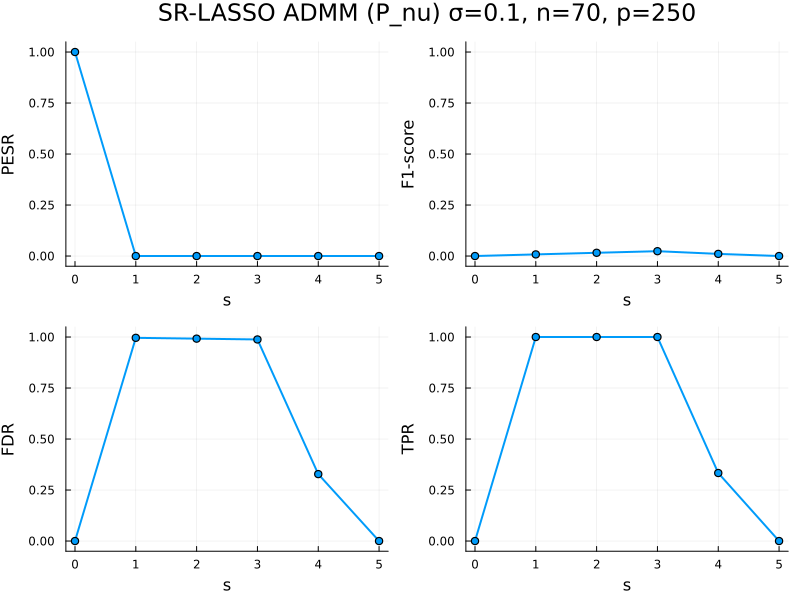

In [13]:
main_title = "SR-LASSO ADMM (P_nu) σ=$sigma, n=$n, p=$p"
plot(
    plot(s, pesr_r; xlabel="s", ylabel="PESR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, f1_r; xlabel="s", ylabel="F1-score", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, fdr_r; xlabel="s", ylabel="FDR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, tpr_r; xlabel="s", ylabel="TPR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    layout =(2, 2), size = (800, 600), plot_title=main_title
)

Je comprends vraiment pas pourquoi les résultats sont si mauvais. 
En regardant les différentes coefficients retournés, on remarque qu'ils ne sont jamais mis à 0 exactement et que si on rajoute une tolérence sur les métriques, cela ne permet pas d'aller bien loin. Peut-être le point de départ est problématique mais il semblerait que le problème ait bien trop changé pour espérer converger vers un bon minimum local (et encore moins global)...
 

Je n'ai pas du tout regardé l'idée initial car désespérer de l'implémentation basique étant bien loin d'une amélioration passant de tout à rien (peut-êtr l'amélioration permet de tout régler mais je doute fortement) (https://arxiv.org/abs/1710.06623)  

# Phases transitions $\ell_1$

# Setup

In [14]:
function lambda_qut_q1(X; B::Int=1000, α::Float64=0.05, seed::Int=42)
    n, p = size(X)
    H = I-ones(n,n)./n
    λs = [
        begin
            u = randn(n)
            Hu = H*u
            maximum(abs.(X'*Hu)) / norm(Hu,2)
        end
        for _ in 1:B
    ]
    return quantile(λs, 1-α)
end

lambda_qut_q1 (generic function with 1 method)

## Phase transition

In [15]:
function phase_transition_ell1(n, p, s_list; σ=0.1, B=20, α=0.05, tol=1e-9, seed=42)
    m = length(s_list)
    pesr_rate = zeros(m)
    f1_rate = zeros(m)
    fdr_rate = zeros(m)
    tpr_rate = zeros(m)

    Random.seed!(42)

    for (i, s) in enumerate(s_list)
        acc_pesr = acc_f1 = acc_fdr = acc_tpr = 0.0

        for _ in 1:B
            X = randn(n, p)
            X .-= mean(X; dims=1)
            X ./= std(X;  dims=1)

            β = zeros(p)
            β[randperm(p)[1:s]] .= 3
            β_hat = run_trial_ell1(X, β, σ; α=α, tol=tol, c_intercept=0)

            y, ŷ = abs.(β) .> 0, abs.(β_hat) .>tol

            acc_pesr += pesr(β, β_hat; tol=tol)
            acc_f1 += f1score(y, ŷ)
            acc_fdr += fdr(y, ŷ)
            acc_tpr += tpr(y, ŷ)
        end

        pesr_rate[i] = acc_pesr/B
        f1_rate[i] = acc_f1 /B
        fdr_rate[i] = acc_fdr/B
        tpr_rate[i] = acc_tpr/B
    end

    return s_list, pesr_rate, f1_rate, fdr_rate, tpr_rate
end

phase_transition_ell1 (generic function with 1 method)

## ADMM ($\ell_1$)

In [16]:
function admm_ell1(X, y, prox; lambda, ρ=1.0, tol=1e-9, max_iter=10_000, verbose=false)
    n, p = size(X)

    θ = zeros(p)
    z = copy(θ)
    u = zeros(n)

    d1 = zeros(p)  # scaled dual for θ - z = 0
    d2 = zeros(n)  # scaled dual for Xθ - y - u = 0

    # Factorize the θ-system: (ρ I + ρ X'X) θ = ρ(z - d1) + ρ X'(y + u - d2)
    A = ρ * (I + X' * X)                # symmetric positive definite
    F = cholesky(Symmetric(A))

    τ = 1 / ρ                           # shrinkage for the ℓ2 prox

    for k in 1:max_iter
        # θ-update (linear system)
        rhs = ρ * (z .- d1) .+ ρ * (X' * (y .+ u .- d2))
        θ = F \ rhs

        # z-update (componentwise soft threshold via provided prox)
        z_old = z
        z = prox(θ .+ d1, lambda / ρ)

        # u-update (vector shrinkage for ℓ2 norm)
        v = X * θ .- y .+ d2
        nv = norm(v)
        if nv > τ
            u_old = u
            u = (1 - τ / nv) * v
        else
            u_old = u
            u = zeros(n)
        end

        # dual updates
        d1 .+= θ .- z
        d2 .+= X * θ .- y .- u

        # residuals (for stopping)
        r1 = θ .- z
        r2 = X * θ .- y .- u
        s  = ρ * (z .- z_old) .+ ρ * (X' * (u .- u_old))

        if max(norm(r1), max(norm(r2), norm(s))) ≤ tol
            if verbose
                @info "ADMM converged at iter $k with ‖r1‖=$(norm(r1)) ‖r2‖=$(norm(r2)) ‖s‖=$(norm(s))"
            end
            break
        end

        if verbose && (k % 1000 == 0)
            @info "iter=$k  ‖r1‖=$(norm(r1))  ‖r2‖=$(norm(r2))  ‖s‖=$(norm(s))"
        end
    end

    return θ
end

admm_ell1 (generic function with 1 method)

In [41]:
function run_trial_ell1(X, β, σ; α=0.05, tol=1e-9, max_iter=10_000, mu=1.0, c_intercept=0.0, verbose=false)
    n, p = size(X)
    X̃ = hcat(X, ones(n))                         # add intercept column
    y  = X * β .+ σ * mu * randn(n) .+ c_intercept

    λ_QUT = lambda_qut_q1(X; α=α, B=1000)

    prox(z, γ) = vcat(sign.(z[1:p]) .* max.(abs.(z[1:p]) .- γ, 0.0), z[p+1])

    ρ = 1.
    θ = admm_ell1(X̃, y, prox;
                  lambda   = λ_QUT,
                  ρ        = ρ,
                  tol      = tol,
                  max_iter = max_iter,
                  verbose  = verbose)

    return θ[1:p]
end


run_trial_ell1 (generic function with 1 method)

In [42]:
n, p = 70, 250
s_lst = 0:15
B_trial = 3
sigma = 0.1

s, pesr_r, f1_r, fdr_r, tpr_r = phase_transition_ell1(n, p, s_lst; σ=sigma, B=B_trial, tol=1e-9)

(0:15, [1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.8888888888888888, 1.0, 1.0, 1.0, 0.8333333333333334, 0.7316017316017316, 0.2833333333333333, 0.4000000000000001, 0.12121212121212122, 0.12121212121212122, 0.2606837606837607, 0.1978021978021978, 0.0, 0.24264705882352944, 0.125], [0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0], [0.0, 1.0, 1.0, 1.0, 1.0, 0.7333333333333334, 0.6666666666666666, 0.19047619047619047, 0.25, 0.07407407407407407, 0.06666666666666667, 0.15151515151515152, 0.1111111111111111, 0.0, 0.14285714285714285, 0.06666666666666667])

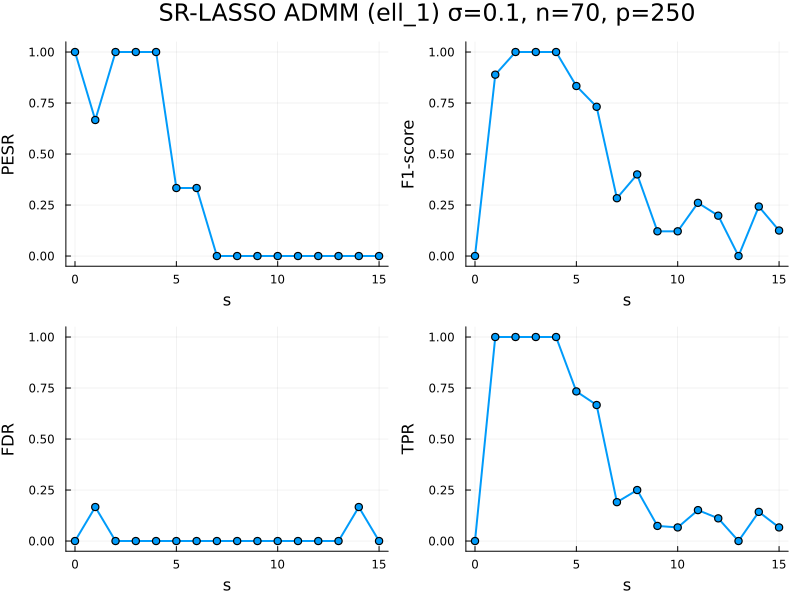

In [43]:
main_title = "SR-LASSO ADMM (ell_1) σ=$sigma, n=$n, p=$p"
plot(
    plot(s, pesr_r; xlabel="s", ylabel="PESR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, f1_r; xlabel="s", ylabel="F1-score", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, fdr_r; xlabel="s", ylabel="FDR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, tpr_r; xlabel="s", ylabel="TPR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    layout =(2, 2), size = (800, 600), plot_title=main_title
)